<a href="https://colab.research.google.com/github/NippunSharma/SVM-implementation-using-SMO/blob/master/SVM(SMO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import sys

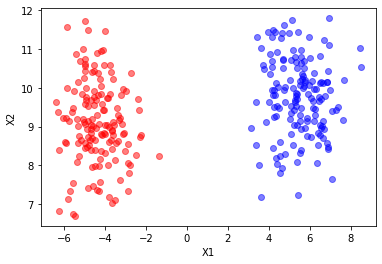

In [383]:
# Making a dataset
N_SAMPLES = 300
N_FEATURES = 2
N_CLASSES = 2
X, y = make_blobs(n_samples=N_SAMPLES, n_features=N_FEATURES, centers=N_CLASSES, random_state=31)
y = y.reshape((N_SAMPLES, 1))
for i in range(N_SAMPLES):
  if(y[i] == 1):
    plt.scatter(X[i][0], X[i][1], color='b', alpha=0.5)
  else:
    y[i] = -1
    plt.scatter(X[i][0], X[i][1], color='r', alpha=0.5)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [0]:
MAX_NUM_ITERATIONS = 100
class SVM:
  def __init__(self, X, y, N_SAMPLES, N_FEATURES, C):
    self._X = X
    self._y = y
    self._n_samples = N_SAMPLES
    self._n_features = N_FEATURES
    self.w = None
    self.b = None
    self.alpha = None
    self.E = None
    self.C = C
    self.eps = 0.0001
    self.tol = 0.001

  def ker(self, x, y):
    return x.dot(y)

  def initialize(self):
    self.w = np.zeros((self._n_features, 1))
    self.b = 0
    self.alpha = np.zeros((self._n_samples, 1))
    self.E = self._X.dot(self.w) - self.b - self._y
  
  def fit(self):
    self.initialize()

    numChanged = 0
    examineAll = 1
    while((numChanged > 0) | (examineAll)):
      numChanged=0

      if(examineAll):
        for i in range(self._n_samples):
          numChanged += self.examineExample(i)
      else:
        for i in range(self._n_samples):
          if(self.alpha[i] == 0 or self.alpha[i] == self.C):
            continue
          else:
            numChanged += self.examineExample(i)
    
      if(examineAll == 1):
        examineAll = 0
      elif(numChanged == 0):
        examineAll = 1
    print('Converged')

  def examineExample(self, i1):
    r1 = self.E[i1][0]*self._y[i1][0]

    count = 0
    for i in range(self._n_samples):
      if(self.alpha[i1][0] == 0 or self.alpha[i1][0] == self.C):
        continue
      else:
        count += 1

    if((r1 < -self.tol and self.alpha[i1][0] < self.C) or (r1 > self.tol and self.alpha[i1][0] > 0)):
      if(count > 1):

        if(self.E[i1][0] > 0):
          i2 = np.argmin(self.E)
        elif(self.E[i1][0] < 0):
          i2 = np.argmax(self.E)
        if(self.takeStep(i1, i2)):
          return 1
      
      initial = np.random.randint(0, self._n_samples)
      for j in range(self._n_samples):
        i = (initial + j)%(self._n_samples)
        if(self.alpha[i1][0] == 0 or self.alpha[i1][0] == self.C):
          continue
        else:
          i2 = i
          if(self.takeStep(i1, i2)):
            return 1
      
      for j in range(self._n_samples):
        j = (initial + j)%(self._n_samples)
        i2 = i
        if(self.takeStep(i1, i2)):
          return 1
    return 0

  def takeStep(self,i1,i2):
    if(i1 == i2):
      return 0

    alpha2_old = self.alpha[i2][0].copy()
    alpha1_old = self.alpha[i1][0].copy()

    s = self._y[i1][0]*self._y[i2][0]

    if(self._y[i1][0] != self._y[i2][0]):
      L = max(0, self.alpha[i2][0] - self.alpha[i1][0])
      H = min(self.C, self.C + self.alpha[i2][0] - self.alpha[i1][0])
    else:
      L = max(0, self.alpha[i2][0] + self.alpha[i1][0] - self.C)
      H = min(self.C, self.alpha[i2][0] + self.alpha[i1][0])
    
    if(L == H):
      return 0
    
    k11 = self.ker(self._X[i1], self._X[i1])
    k12 = self.ker(self._X[i1], self._X[i2])
    k22 = self.ker(self._X[i2], self._X[i2])

    eta = k11 + k22 - 2*k12

    if(eta > 0):
      self.alpha[i2][0] += self._y[i2][0]*(self.E[i1][0] - self.E[i2][0])/eta
      if(np.isnan(self.alpha[i2][0])):
        print('Found alpha to be NaN')
        sys.exit()
  
      if(self.alpha[i2][0] < L): self.alpha[i2][0] = L
      elif(self.alpha[i2][0] > H): self.alpha[i2][0] = H
    elif(eta <= 0):
      print('Found eta -ve or zero')
      sys.exit()
    
    if(abs(alpha2_old - self.alpha[i2][0]) < self.eps*(alpha2_old + self.alpha[i2][0] + self.eps)):
      return 0
    
    self.alpha[i1][0] += s*(alpha2_old - self.alpha[i2][0])

    b1 = self.E[i1][0] + self.b + self._y[i1][0]*(self.alpha[i1][0] - alpha1_old)*self.ker(self._X[i1], self._X[i1]) + self._y[i2][0]*(self.alpha[i2][0] - alpha2_old)*self.ker(self._X[i1], self._X[i2])
    b2 = self.E[i2][0] + self.b + self._y[i1][0]*(self.alpha[i1][0] - alpha1_old)*self.ker(self._X[i1], self._X[i2]) + self._y[i2][0]*(self.alpha[i2][0] - alpha2_old)*self.ker(self._X[i2], self._X[i2])
    if(self.alpha[i1][0] > 0 and self.alpha[i1][0] < self.C):
      self.b = b1
    elif(self.alpha[i2][0] > 0 and self.alpha[i2][0] < self.C):
      self.b = b2
    else:
      self.b = (b1 + b2)/2      
    
    self.w += self._y[i1][0]*(self.alpha[i1][0] - alpha1_old)*self._X[i1].reshape((self._n_features,1)) + self._y[i2][0]*(self.alpha[i2][0] - alpha2_old)*self._X[i2].reshape((self._n_features, 1))
    
    self.E[i1][0] = self._X[i1].dot(self.w) - self.b - self._y[i1][0]
    self.E[i2][0] = self._X[i2].dot(self.w) - self.b - self._y[i2][0]

    return 1

In [388]:
w, b = [], []
for i in range(100):
  print(i)
  model = SVM(X, y, 200, 2, 4.5)
  model.fit()
  w.append(model.w)
  b.append(model.b)

0
Converged
1
Converged
2
Converged
3
Converged
4
Converged
5
Converged
6
Converged
7
Converged
8
Converged
9
Converged
10
Converged
11
Converged
12
Converged
13
Converged
14
Converged
15
Converged
16
Converged
17
Converged
18
Converged
19
Converged
20
Converged
21
Converged
22
Converged
23
Converged
24
Converged
25
Converged
26
Converged
27
Converged
28
Converged
29
Converged
30
Converged
31
Converged
32
Converged
33
Converged
34
Converged
35
Converged
36
Converged
37
Converged
38
Converged
39
Converged
40
Converged
41
Converged
42
Converged
43
Converged
44
Converged
45
Converged
46
Converged
47
Converged
48
Converged
49
Converged
50
Converged
51
Converged
52
Converged
53
Converged
54
Converged
55
Converged
56
Converged
57
Converged
58
Converged
59
Converged
60
Converged
61
Converged
62
Converged
63
Converged
64
Converged
65
Converged
66
Converged
67
Converged
68
Converged
69
Converged
70
Converged
71
Converged
72
Converged
73
Converged
74
Converged
75
Converged
76
Converged
77
Conver

2528.8035423065203
[[2020.56244125]
 [ 109.55673769]]


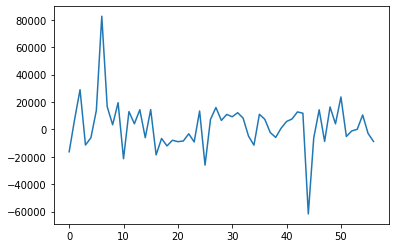

In [389]:
w = np.array(w)
b = np.array(b)

plt.plot(range(len(b[abs(b) < 90000])), b[abs(b) < 90000])
print(np.mean(b[abs(b) < 90000]))
print(np.median(w, axis=0))

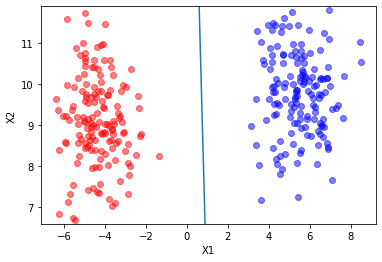

In [390]:
x_range = np.arange(min(X[:,0]), max(X[:,0]), 0.1)

for i in range(N_SAMPLES):
  if(y[i] == 1):
    plt.scatter(X[i][0], X[i][1], color='b', alpha=0.5)
  else:
    y[i] = -1
    plt.scatter(X[i][0], X[i][1], color='r', alpha=0.5)
plt.plot(x_range, (-x_range*(np.median(w,axis=0)[0][0]) + np.mean(b[abs(b) < 90000]))/np.median(w, axis=0)[1][0])
plt.xlabel('X1')
plt.ylabel('X2')
plt.ylim(min(X[:,1]) - 0.1, max(X[:,1]) + 0.1)
plt.show()